In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.discrete_diffusers as discrete_diffusers
import model.generate as generate
import model.image_unet as image_unet
import model.util as model_util
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
# classes = [0, 4, 9]
# branch_defs = [
#     ((0, 4, 9), 650, 1000),
#     ((0,), 0, 650),
#     ((4, 9), 550, 650),
#     ((4,), 0, 550),
#     ((9,), 0, 550)
# ]

# classes = [0]
# branch_defs = [
#     ((0,), 0, 1000)
# ]

classes = list(range(10))
branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 761, 1000), ((0, 2, 3, 4, 5, 6, 7, 8, 9), 760, 761), ((2, 3, 4, 5, 6, 7, 8, 9), 712, 760), ((3, 4, 5, 6, 7, 8, 9), 709, 712), ((3, 5, 6, 8), 700, 709), ((4, 7, 9), 685, 709), ((3, 5, 8), 659, 700), ((3, 5), 656, 659), ((4, 9), 527, 685), ((1,), 0, 761), ((0,), 0, 760), ((2,), 0, 712), ((6,), 0, 700), ((7,), 0, 685), ((8,), 0, 659), ((5,), 0, 656), ((3,), 0, 656), ((4,), 0, 527), ((9,), 0, 527)]

dataset = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]

In [4]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

### Create the model

In [5]:
# Create the diffuser and model
diffuser = discrete_diffusers.GaussianDiffuser(1e-4, 1e-5, input_shape)

t_limit = 1000

model = image_unet.MultitaskMNISTUNetTimeConcat(
    len(branch_defs), t_limit=t_limit
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/mnist_discrete_alldigits"

import model.train_discrete_model as train_discrete_model  # Import this AFTER setting environment

### Show the forward-diffusion process

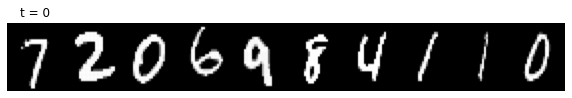

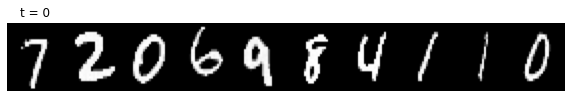

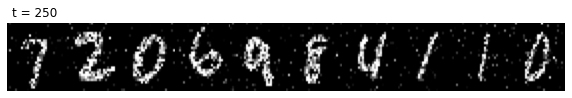

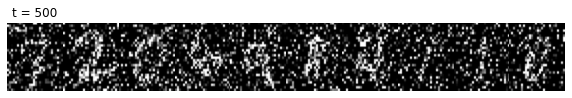

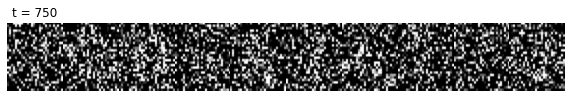

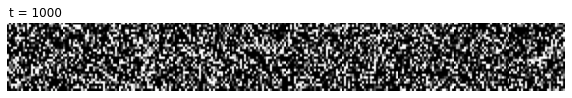

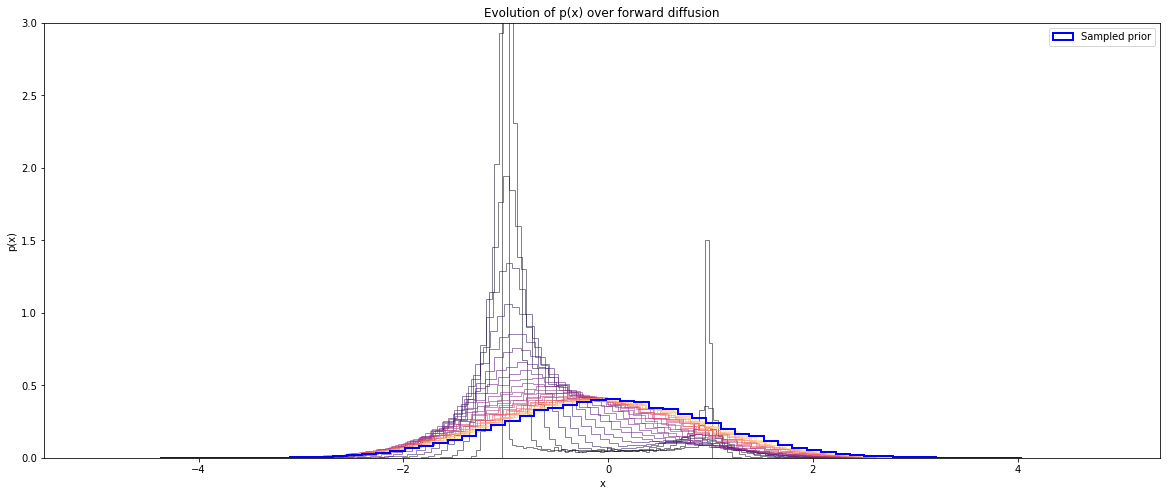

In [6]:
# Show some images after running the diffuser forward for different times
time_steps = 4

x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()

plot_mnist_digits(x0, grid_size=(10, 1), title="t = 0")
x0 = torch.tensor(x0).to(DEVICE)
for t in np.arange(0, t_limit + 1, t_limit // time_steps):
    xt, score = diffuser.forward(x0, torch.full(x0.shape[:1], t).to(DEVICE))
    plot_mnist_digits(xt.cpu().numpy(), grid_size=(10, 1), title=("t = %d" % t))
    
# Show the transformation of the distribution of data to the prior distribution
time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = diffuser.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = diffuser.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward diffusion")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [7]:
train_discrete_model.train_ex.run(
    "train_branched_model",
    config_updates={
        "model": model,
        "diffuser": diffuser,
        "data_loader": data_loader,
        "class_time_to_branch_index": class_time_to_branch_tensor,
        "num_epochs": 200,
        "learning_rate": 0.001,
        "t_limit": t_limit
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "diffuser"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "2"
Loss: 107.15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:01<00:00,  3.87it/s]


Epoch 1 average Loss: 225.85


Loss: 67.93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.88it/s]


Epoch 2 average Loss: 90.50


Loss: 65.34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:35<00:00,  4.89it/s]


Epoch 3 average Loss: 70.14


Loss: 63.59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.87it/s]


Epoch 4 average Loss: 61.13


Loss: 52.23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:35<00:00,  4.89it/s]


Epoch 5 average Loss: 55.52


Loss: 48.91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:35<00:00,  4.89it/s]


Epoch 6 average Loss: 52.78


Loss: 54.69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:35<00:00,  4.90it/s]


Epoch 7 average Loss: 49.16


Loss: 52.08: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:01<00:00,  3.85it/s]


Epoch 8 average Loss: 47.04


Loss: 41.71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:35<00:00,  4.90it/s]


Epoch 9 average Loss: 45.58


Loss: 45.91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.88it/s]


Epoch 10 average Loss: 44.09


Loss: 40.27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:00<00:00,  3.90it/s]


Epoch 11 average Loss: 42.73


Loss: 39.77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:58<00:00,  3.96it/s]


Epoch 12 average Loss: 41.73


Loss: 35.81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.88it/s]


Epoch 13 average Loss: 40.96


Loss: 38.61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.87it/s]


Epoch 14 average Loss: 39.88


Loss: 40.83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:03<00:00,  3.80it/s]


Epoch 15 average Loss: 39.21


Loss: 39.19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:05<00:00,  3.73it/s]


Epoch 16 average Loss: 38.25


Loss: 35.08: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:33<00:00,  3.06it/s]


Epoch 17 average Loss: 38.02


Loss: 36.74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:31<00:00,  3.09it/s]


Epoch 18 average Loss: 37.62


Loss: 37.67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.85it/s]


Epoch 19 average Loss: 36.99


Loss: 33.91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:26<00:00,  3.19it/s]


Epoch 20 average Loss: 36.24


Loss: 38.11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:32<00:00,  3.07it/s]


Epoch 21 average Loss: 36.12


Loss: 37.66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:06<00:00,  3.71it/s]


Epoch 22 average Loss: 36.01


Loss: 32.18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.88it/s]


Epoch 23 average Loss: 35.45


Loss: 37.93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.88it/s]


Epoch 24 average Loss: 35.44


Loss: 32.09: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.87it/s]


Epoch 25 average Loss: 35.13


Loss: 41.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:35<00:00,  4.89it/s]


Epoch 26 average Loss: 34.94


Loss: 35.13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.88it/s]


Epoch 27 average Loss: 34.41


Loss: 33.61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.88it/s]


Epoch 28 average Loss: 34.15


Loss: 39.56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.88it/s]


Epoch 29 average Loss: 34.01


Loss: 33.52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.88it/s]


Epoch 30 average Loss: 33.76


Loss: 38.86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.87it/s]


Epoch 31 average Loss: 33.96


Loss: 35.79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.88it/s]


Epoch 32 average Loss: 33.66


Loss: 34.12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.88it/s]


Epoch 33 average Loss: 33.22


Loss: 34.97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:39<00:00,  4.71it/s]


Epoch 34 average Loss: 33.31


Loss: 28.46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:40<00:00,  4.67it/s]


Epoch 35 average Loss: 33.35


Loss: 40.06: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.81it/s]


Epoch 36 average Loss: 32.78


Loss: 36.15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.88it/s]


Epoch 37 average Loss: 32.61


Loss: 32.61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.87it/s]


Epoch 38 average Loss: 32.61


Loss: 29.57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.89it/s]


Epoch 39 average Loss: 32.59


Loss: 32.72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.87it/s]


Epoch 40 average Loss: 32.47


Loss: 32.01: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.87it/s]


Epoch 41 average Loss: 32.23


Loss: 29.72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.87it/s]


Epoch 42 average Loss: 32.19


Loss: 26.37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.86it/s]


Epoch 43 average Loss: 31.87


Loss: 32.71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.84it/s]


Epoch 44 average Loss: 31.88


Loss: 30.65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.82it/s]


Epoch 45 average Loss: 32.03


Loss: 25.99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.86it/s]


Epoch 46 average Loss: 32.00


Loss: 25.41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.86it/s]


Epoch 47 average Loss: 31.72


Loss: 32.27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.87it/s]


Epoch 48 average Loss: 31.65


Loss: 29.48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.87it/s]


Epoch 49 average Loss: 31.42


Loss: 31.78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.87it/s]


Epoch 50 average Loss: 31.37


Loss: 25.21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.87it/s]


Epoch 51 average Loss: 31.21


Loss: 33.64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.86it/s]


Epoch 52 average Loss: 31.42


Loss: 34.90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.87it/s]


Epoch 53 average Loss: 31.17


Loss: 29.57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.86it/s]


Epoch 54 average Loss: 31.01


Loss: 30.73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.87it/s]


Epoch 55 average Loss: 31.00


Loss: 31.00: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.86it/s]


Epoch 56 average Loss: 30.96


Loss: 40.26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.87it/s]


Epoch 57 average Loss: 30.83


Loss: 34.13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.86it/s]


Epoch 58 average Loss: 30.93


Loss: 34.70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.87it/s]


Epoch 59 average Loss: 30.73


Loss: 28.08: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:57<00:00,  3.98it/s]


Epoch 60 average Loss: 30.50


Loss: 24.73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:34<00:00,  3.04it/s]


Epoch 61 average Loss: 30.67


Loss: 35.97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:33<00:00,  3.06it/s]


Epoch 62 average Loss: 30.70


Loss: 28.05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.85it/s]


Epoch 63 average Loss: 30.35


Loss: 35.81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.86it/s]


Epoch 64 average Loss: 30.54


Loss: 34.49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:52<00:00,  4.17it/s]


Epoch 65 average Loss: 30.51


Loss: 33.99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:33<00:00,  3.06it/s]


Epoch 66 average Loss: 30.62


Loss: 28.72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:38<00:00,  2.96it/s]


Epoch 67 average Loss: 30.17


Loss: 29.05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.76it/s]


Epoch 68 average Loss: 30.35


Loss: 30.91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.86it/s]


Epoch 69 average Loss: 30.02


Loss: 29.24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.85it/s]


Epoch 70 average Loss: 30.27


Loss: 27.17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.86it/s]


Epoch 71 average Loss: 29.96


Loss: 33.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.86it/s]


Epoch 72 average Loss: 30.19


Loss: 32.42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.86it/s]


Epoch 73 average Loss: 29.94


Loss: 28.01: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.85it/s]


Epoch 74 average Loss: 29.86


Loss: 28.78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.86it/s]


Epoch 75 average Loss: 29.91


Loss: 27.16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.86it/s]


Epoch 76 average Loss: 29.82


Loss: 29.21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.85it/s]


Epoch 77 average Loss: 29.85


Loss: 28.60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.83it/s]


Epoch 78 average Loss: 30.14


Loss: 25.76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.85it/s]


Epoch 79 average Loss: 29.83


Loss: 31.01: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.84it/s]


Epoch 80 average Loss: 29.98


Loss: 27.18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.85it/s]


Epoch 81 average Loss: 29.92


Loss: 28.47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.84it/s]


Epoch 82 average Loss: 29.63


Loss: 28.24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.83it/s]


Epoch 83 average Loss: 29.76


Loss: 29.68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:54<00:00,  4.09it/s]


Epoch 84 average Loss: 29.51


Loss: 33.10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.83it/s]


Epoch 85 average Loss: 29.90


Loss: 27.49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.84it/s]


Epoch 86 average Loss: 29.51


Loss: 29.51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.85it/s]


Epoch 87 average Loss: 29.35


Loss: 24.53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:50<00:00,  4.26it/s]


Epoch 88 average Loss: 29.42


Loss: 27.05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:50<00:00,  4.23it/s]


Epoch 89 average Loss: 29.38


Loss: 40.26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:45<00:00,  4.43it/s]


Epoch 90 average Loss: 29.34


Loss: 25.43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.84it/s]


Epoch 91 average Loss: 29.30


Loss: 32.52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:55<00:00,  4.07it/s]


Epoch 92 average Loss: 29.36


Loss: 29.84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:05<00:00,  3.74it/s]


Epoch 93 average Loss: 29.37


Loss: 27.69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.84it/s]


Epoch 94 average Loss: 29.20


Loss: 28.91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.84it/s]


Epoch 95 average Loss: 29.12


Loss: 33.17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.84it/s]


Epoch 96 average Loss: 29.40


Loss: 34.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.84it/s]


Epoch 97 average Loss: 29.44


Loss: 28.79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.84it/s]


Epoch 98 average Loss: 28.98


Loss: 31.87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.85it/s]


Epoch 99 average Loss: 29.09


Loss: 35.59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.84it/s]


Epoch 100 average Loss: 29.31


Loss: 28.77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.83it/s]


Epoch 101 average Loss: 29.09


Loss: 26.15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.84it/s]


Epoch 102 average Loss: 28.95


Loss: 20.83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.83it/s]


Epoch 103 average Loss: 28.85


Loss: 26.17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:06<00:00,  3.72it/s]


Epoch 104 average Loss: 28.94


Loss: 28.57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.83it/s]


Epoch 105 average Loss: 28.97


Loss: 25.34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.84it/s]


Epoch 106 average Loss: 28.79


Loss: 31.64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:02<00:00,  3.82it/s]


Epoch 107 average Loss: 29.13


Loss: 35.10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:39<00:00,  4.69it/s]


Epoch 108 average Loss: 28.87


Loss: 33.86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.84it/s]


Epoch 109 average Loss: 29.19


Loss: 27.36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:36<00:00,  4.84it/s]


Epoch 110 average Loss: 28.96


Loss: 24.20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.82it/s]


Epoch 111 average Loss: 28.81


Loss: 29.75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.81it/s]


Epoch 112 average Loss: 28.85


Loss: 27.38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.82it/s]


Epoch 113 average Loss: 28.69


Loss: 30.64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.82it/s]


Epoch 114 average Loss: 28.72


Loss: 28.11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.83it/s]


Epoch 115 average Loss: 28.64


Loss: 29.60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.82it/s]


Epoch 116 average Loss: 28.89


Loss: 28.90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.82it/s]


Epoch 117 average Loss: 28.78


Loss: 33.01: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:05<00:00,  3.75it/s]


Epoch 118 average Loss: 28.74


Loss: 25.50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.83it/s]


Epoch 119 average Loss: 28.69


Loss: 28.05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.82it/s]


Epoch 120 average Loss: 28.58


Loss: 25.19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.83it/s]


Epoch 121 average Loss: 28.70


Loss: 28.53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:02<00:00,  3.83it/s]


Epoch 122 average Loss: 28.59


Loss: 27.35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:07<00:00,  3.68it/s]


Epoch 123 average Loss: 28.56


Loss: 27.51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.81it/s]


Epoch 124 average Loss: 28.62


Loss: 25.52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.82it/s]


Epoch 125 average Loss: 28.60


Loss: 26.19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.83it/s]


Epoch 126 average Loss: 28.53


Loss: 25.61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.82it/s]


Epoch 127 average Loss: 28.39


Loss: 23.62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.83it/s]


Epoch 128 average Loss: 28.51


Loss: 34.53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.81it/s]


Epoch 129 average Loss: 28.46


Loss: 31.14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 130 average Loss: 28.43


Loss: 28.85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.81it/s]


Epoch 131 average Loss: 28.52


Loss: 27.21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 132 average Loss: 28.41


Loss: 31.07: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.81it/s]


Epoch 133 average Loss: 28.45


Loss: 28.99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.81it/s]


Epoch 134 average Loss: 28.40


Loss: 25.39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.77it/s]


Epoch 135 average Loss: 28.45


Loss: 29.40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.81it/s]


Epoch 136 average Loss: 28.38


Loss: 35.15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 137 average Loss: 28.44


Loss: 25.59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.81it/s]


Epoch 138 average Loss: 28.56


Loss: 35.60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 139 average Loss: 28.16


Loss: 29.69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.81it/s]


Epoch 140 average Loss: 28.12


Loss: 34.68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 141 average Loss: 28.17


Loss: 26.17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 142 average Loss: 28.10


Loss: 31.38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.82it/s]


Epoch 143 average Loss: 28.33


Loss: 21.85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 144 average Loss: 27.97


Loss: 29.60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 145 average Loss: 28.05


Loss: 25.60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.81it/s]


Epoch 146 average Loss: 28.31


Loss: 30.46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 147 average Loss: 28.40


Loss: 30.28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.81it/s]


Epoch 148 average Loss: 28.00


Loss: 25.06: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 149 average Loss: 28.30


Loss: 27.06: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.81it/s]


Epoch 150 average Loss: 27.98


Loss: 26.63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.81it/s]


Epoch 151 average Loss: 28.09


Loss: 30.41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 152 average Loss: 27.99


Loss: 31.59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 153 average Loss: 27.96


Loss: 29.40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 154 average Loss: 28.03


Loss: 29.59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.81it/s]


Epoch 155 average Loss: 28.02


Loss: 25.80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.79it/s]


Epoch 156 average Loss: 28.10


Loss: 31.75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.79it/s]


Epoch 157 average Loss: 27.71


Loss: 31.36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 158 average Loss: 28.09


Loss: 30.61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 159 average Loss: 27.92


Loss: 27.66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 160 average Loss: 27.97


Loss: 31.38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.78it/s]


Epoch 161 average Loss: 27.91


Loss: 26.90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.81it/s]


Epoch 162 average Loss: 27.81


Loss: 28.47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 163 average Loss: 27.77


Loss: 27.74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.79it/s]


Epoch 164 average Loss: 28.06


Loss: 23.08: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.79it/s]


Epoch 165 average Loss: 27.96


Loss: 31.24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.79it/s]


Epoch 166 average Loss: 27.86


Loss: 35.37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:07<00:00,  3.68it/s]


Epoch 167 average Loss: 28.17


Loss: 30.93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [05:04<00:00,  1.54it/s]


Epoch 168 average Loss: 27.85


Loss: 31.96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [06:19<00:00,  1.24it/s]


Epoch 169 average Loss: 27.77


Loss: 26.41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:43<00:00,  4.55it/s]


Epoch 170 average Loss: 27.78


Loss: 30.83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:42<00:00,  4.56it/s]


Epoch 171 average Loss: 27.81


Loss: 25.02: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:42<00:00,  4.56it/s]


Epoch 172 average Loss: 27.53


Loss: 26.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:42<00:00,  4.56it/s]


Epoch 173 average Loss: 27.58


Loss: 26.29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:43<00:00,  4.55it/s]


Epoch 174 average Loss: 27.52


Loss: 24.50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.78it/s]


Epoch 175 average Loss: 27.69


Loss: 25.34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 176 average Loss: 27.70


Loss: 27.43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.79it/s]


Epoch 177 average Loss: 27.49


Loss: 25.96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.77it/s]


Epoch 178 average Loss: 27.71


Loss: 30.83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.80it/s]


Epoch 179 average Loss: 27.63


Loss: 28.04: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.78it/s]


Epoch 180 average Loss: 27.86


Loss: 26.84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.79it/s]


Epoch 181 average Loss: 27.36


Loss: 24.48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.78it/s]


Epoch 182 average Loss: 27.68


Loss: 23.88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.77it/s]


Epoch 183 average Loss: 27.81


Loss: 23.16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.78it/s]


Epoch 184 average Loss: 27.48


Loss: 22.86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.78it/s]


Epoch 185 average Loss: 27.82


Loss: 29.38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.79it/s]


Epoch 186 average Loss: 27.49


Loss: 28.46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.78it/s]


Epoch 187 average Loss: 27.54


Loss: 28.50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.77it/s]


Epoch 188 average Loss: 27.44


Loss: 27.26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:37<00:00,  4.79it/s]


Epoch 189 average Loss: 27.37


Loss: 34.86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.77it/s]


Epoch 190 average Loss: 27.64


Loss: 25.99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.76it/s]


Epoch 191 average Loss: 27.56


Loss: 25.91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.77it/s]


Epoch 192 average Loss: 27.35


Loss: 27.43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.76it/s]


Epoch 193 average Loss: 27.50


Loss: 24.50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.78it/s]


Epoch 194 average Loss: 27.44


Loss: 28.64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.77it/s]


Epoch 195 average Loss: 27.39


Loss: 20.70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.78it/s]


Epoch 196 average Loss: 27.67


Loss: 29.17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.76it/s]


Epoch 197 average Loss: 27.20


Loss: 24.29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.77it/s]


Epoch 198 average Loss: 27.26


Loss: 25.25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.78it/s]


Epoch 199 average Loss: 27.35


Loss: 30.08: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.75it/s]
INFO - train - Completed after 5:48:28


Epoch 200 average Loss: 27.44


### Show generated digits

Sampling class: 0


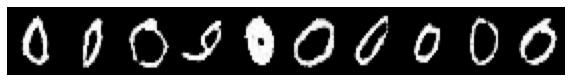

Sampling class: 1


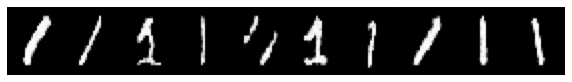

Sampling class: 2


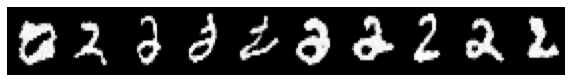

Sampling class: 3


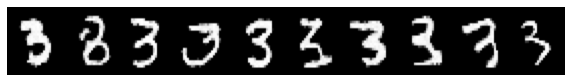

Sampling class: 4


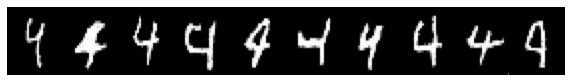

Sampling class: 5


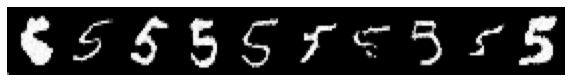

Sampling class: 6


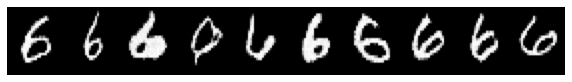

Sampling class: 7


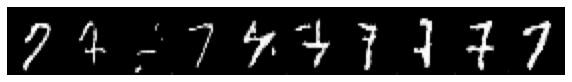

Sampling class: 8


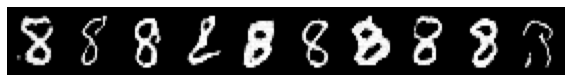

Sampling class: 9


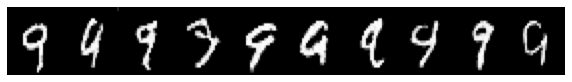

In [8]:
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_discrete_branched_samples(
        model, diffuser, class_to_sample, class_time_to_branch_tensor,
        t_limit=t_limit
    )
    plot_mnist_digits(samples.cpu().numpy(), grid_size=(10, 1), title=None)

**Intermediate states**

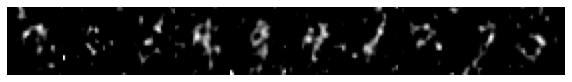

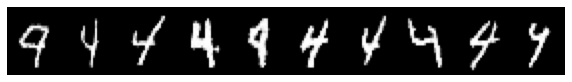

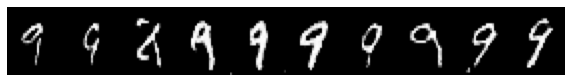

In [9]:
branch_time_4_9 = 550

samples_49 = generate.generate_discrete_branched_samples(
    model, diffuser, 4, class_time_to_branch_tensor, t_start=branch_time_4_9,
    t_limit=t_limit
).cpu().numpy()
samples_4 = generate.generate_discrete_branched_samples(
    model, diffuser, 4, class_time_to_branch_tensor, t_limit=branch_time_4_9,
    initial_samples=torch.tensor(samples_49).to(DEVICE)
).cpu().numpy()
samples_9 = generate.generate_discrete_branched_samples(
    model, diffuser, 9, class_time_to_branch_tensor, t_limit=branch_time_4_9,
    initial_samples=torch.tensor(samples_49).to(DEVICE)
).cpu().numpy()

smoothed_samples_49 = np.empty_like(samples_49)
for i in range(len(samples_49)):
    smoothed_samples_49[i, 0] = scipy.ndimage.gaussian_filter(samples_49[i, 0], sigma=1)
    
plot_mnist_digits(smoothed_samples_49)
plot_mnist_digits(samples_4)
plot_mnist_digits(samples_9)

**Diffusing from one class to another**

/local/57022068/ipykernel_24615/2920388320.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  orig_4_tens, orig_9_tens = torch.tensor(orig_4).to(DEVICE), torch.tensor(orig_9).to(DEVICE)


4 to 9


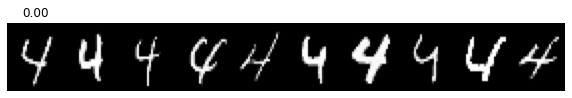

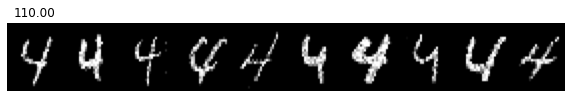

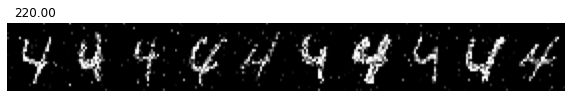

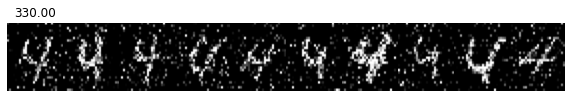

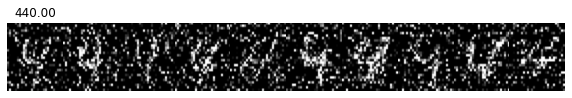

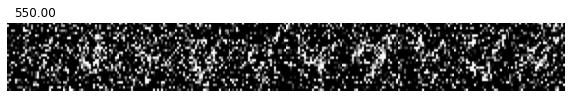

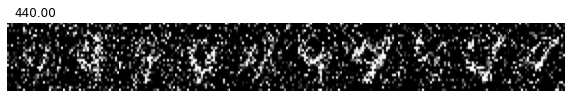

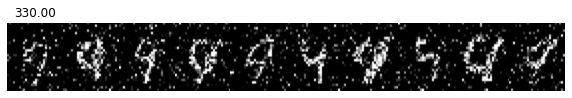

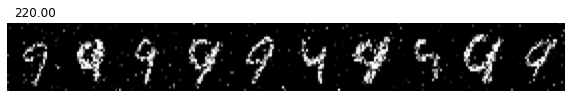

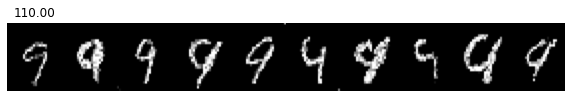

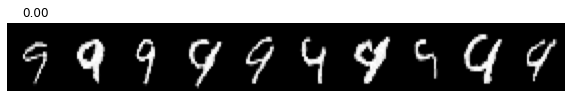

9 to 4


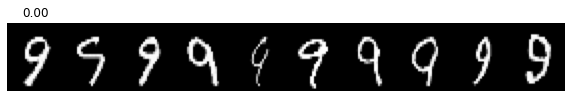

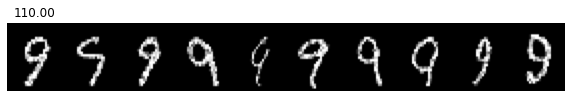

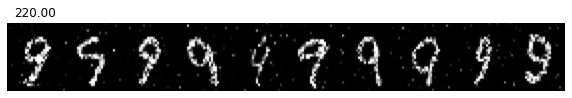

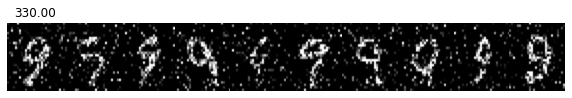

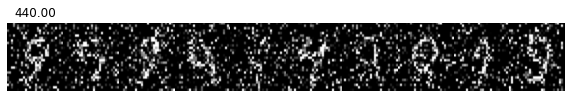

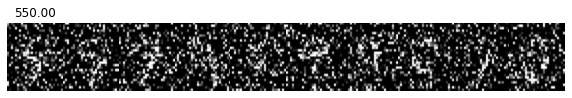

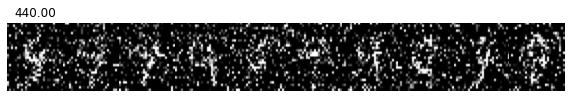

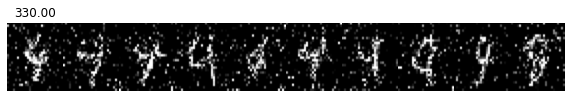

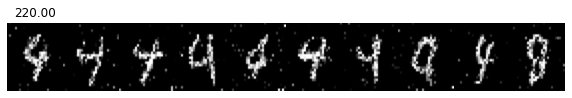

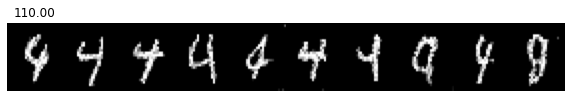

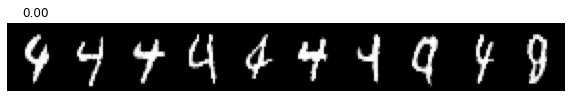

In [10]:
orig_4 = torch.stack([
    torch.tensor(dataset[i][0], device=DEVICE) for i in 
    np.random.choice(np.where(dataset.targets == 4)[0], size=32, replace=False)
])
orig_9 = torch.stack([
    torch.tensor(dataset[i][0], device=DEVICE) for i in 
    np.random.choice(np.where(dataset.targets == 9)[0], size=32, replace=False)
])

time_steps = 5
all_t = np.arange(0, branch_time_4_9 + 1, branch_time_4_9 // time_steps)
forward_4_to_9 = np.empty((len(all_t),) + orig_4.shape)
backward_4_to_9 = np.empty((len(all_t) - 1,) + orig_4.shape)
forward_9_to_4 = np.empty((len(all_t),) + orig_4.shape)
backward_9_to_4 = np.empty((len(all_t) - 1,) + orig_4.shape)
orig_4_tens, orig_9_tens = torch.tensor(orig_4).to(DEVICE), torch.tensor(orig_9).to(DEVICE)
for t_i, t in enumerate(all_t):
    forward_4_to_9[t_i] = diffuser.forward(
        orig_4_tens, torch.ones(len(orig_4_tens)).to(DEVICE) * t
    )[0].cpu().numpy()
    forward_9_to_4[t_i] = diffuser.forward(
        orig_9_tens, torch.ones(len(orig_9_tens)).to(DEVICE) * t
    )[0].cpu().numpy()

all_t_flip = np.flip(all_t)
last_4_to_9 = torch.tensor(forward_4_to_9[-1]).to(DEVICE).float()
last_9_to_4 = torch.tensor(forward_9_to_4[-1]).to(DEVICE).float()
for t_i in range(len(all_t_flip) - 1):
    last_4_to_9 = generate.generate_discrete_branched_samples(
        model, diffuser, 9, class_time_to_branch_tensor,
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_4.shape[0], initial_samples=last_4_to_9
    )
    backward_4_to_9[t_i] = last_4_to_9.cpu().numpy()
    
    last_9_to_4 = generate.generate_discrete_branched_samples(
        model, diffuser, 4, class_time_to_branch_tensor,
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_9.shape[0], initial_samples=last_9_to_4
    )
    backward_9_to_4[t_i] = last_9_to_4.cpu().numpy()
    
print("4 to 9")
for t_i, t in enumerate(all_t):
    plot_mnist_digits(forward_4_to_9[t_i], title=("%.2f" % t))
for t_i, t in enumerate(all_t_flip[1:]):
    plot_mnist_digits(backward_4_to_9[t_i], title=("%.2f" % t))

print("9 to 4")
for t_i, t in enumerate(all_t):
    plot_mnist_digits(forward_9_to_4[t_i], title=("%.2f" % t))
for t_i, t in enumerate(all_t_flip[1:]):
    plot_mnist_digits(backward_9_to_4[t_i], title=("%.2f" % t))